# Notebook to explore lat/long position of wells & find nearest neighbors
### and potentially functions to make a dataset of nearest neighbors within certain limits for each well
### and potentially functions to make a dataset of tops and other characteristics for neighboring wells.

In [178]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)

folium 0.5.0
welly 0.3.5


In [2]:
%%timeit
import os
env = %env

83.3 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
pd.set_option('display.max_rows', 2000)

In [5]:
picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../well_lat_lng.csv')
picks_new=picks[picks['HorID']==13000]
picks_paleoz=picks[picks['HorID']==14000]
df_new = pd.merge(wells, picks_new, on='SitID')
df_paleoz = pd.merge(wells, picks_paleoz, on='SitID')
#### NOTE: This now includes the GIS or well_lat_lng dataset too!
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

## Possible Steps to Chain for some of the possible features
0. Save and access pickle of all the CSVs chained into single data frame
1. Return array of UWIs of K neighbor wells, place as list in data frame
2. Place nearest well UWI of each well into new column 
3. Place nearest well pick depths into new column
4. place average pick depths of the array of wells into new column
5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
6. Calculate nearest and average value for distance between pick in question and known pick.

In [6]:
position = df_new[['lat','lng']]

In [7]:
position

lat         lng
0     54.785907 -110.129320
1     54.782284 -110.269446
2     54.785892 -110.186851
3     54.829624 -110.269422
4     54.840471 -110.224832
5     54.771449 -110.402983
6     54.785901 -110.422131
7     54.800533 -110.345762
8     54.829633 -110.396621
9     54.840441 -110.320301
10    54.771451 -110.498414
11    54.785896 -110.599928
12    54.814989 -110.479147
13    54.840482 -110.549109
14    54.775090 -110.688675
15    54.796954 -110.707896
16    54.826012 -110.625318
17    54.844116 -110.701599
18    54.775087 -110.777910
19    54.796947 -110.885862
20    54.811402 -110.803309
21    54.822471 -110.879581
22    54.771468 -111.038407
23    54.796937 -110.936727
24    54.822460 -110.936727
25    54.826041 -111.025865
26    54.771478 -111.133860
27    54.796927 -111.089256
28    54.829658 -111.184726
29    54.840503 -111.133864
30    54.826009 -111.445246
31    54.844056 -111.508948
32    54.764109 -111.674106
33    54.844075 -111.616965
34    54.767736 -111.718675
35    54.767676 -111.788610
36    54.796863 -111.699581
37    54.811292 -111.737853
38    54.771211 -111.902778
39    54.778455 -111.883638
40    54.843896 -111.896572
41    54.843897 -111.852009
42    54.767516 -112.055371
43    54.785519 -112.112394
44    54.785555 -112.055334
45    54.803748 -112.137831
46    54.767425 -112.169807
47    54.770993 -112.277768
48    54.814564 -112.207734
49    54.839992 -112.284017
50    54.782042 -112.430364
51    54.785454 -112.309435
52    54.807482 -112.411225
53    54.836517 -112.360351
54    54.785676 -112.557536
55    54.782048 -112.487492
56    54.818389 -112.570115
57    54.840261 -112.557543
58    54.774904 -112.665458
59    54.785734 -112.665460
60    54.825775 -112.627548
61    54.829416 -112.735380
62    54.873181 -110.123115
63    54.873181 -110.269399
64    54.873176 -110.186834
65    54.913308 -110.199382
66    54.916925 -110.275652
67    54.858728 -110.415740
68    54.884202 -110.326522
69    54.884217 -110.396549
70    54.916935 -110.396506
71    54.858730 -110.504559
72    54.869577 -110.555355
73    54.916928 -110.498201
74    54.913303 -110.580733
75    54.869595 -110.727018
76    54.869560 -110.625306
77    54.887844 -110.707861
78    54.920534 -110.650717
79    54.855130 -110.777878
80    54.884229 -110.828717
81    54.902274 -110.911297
82    54.913322 -110.828714
83    54.862358 -111.038422
84    54.887816 -111.070126
85    54.913311 -110.962152
86    54.913315 -111.044628
87    54.862363 -111.184725
88    54.905916 -111.153019
89    54.909749 -111.102157
90    54.920527 -111.222627
91    54.895029 -111.368963
92    54.913308 -111.311852
93    54.898635 -111.489848
94    54.927733 -111.388128
95    54.855083 -111.629538
96    54.876765 -111.629562
97    54.913273 -111.604145
98    54.916890 -111.597866
99    54.920494 -111.674156
100   54.880391 -111.826646
101   54.898593 -111.725000
102   54.916768 -111.801237
103   54.927575 -111.826639
104   54.858597 -111.896690
105   54.873029 -111.851923
106   54.916755 -111.896661
107   54.927590 -111.896637
108   54.902133 -112.055391
109   54.916751 -112.004556
110   54.927594 -112.049124
111   54.931203 -112.284175
112   54.858266 -112.309458
113   54.887466 -112.354046
114   54.913040 -112.404936
115   54.931141 -112.411269
116   54.872959 -112.589292
117   54.873000 -112.462096
118   54.887595 -112.595535
119   54.913081 -112.582980
120   54.858523 -112.665477
121   54.872978 -112.665485
122   54.913116 -112.665482
123   54.927560 -112.741762
124   54.956857 -110.301060
125   55.004218 -110.371054
126   54.942407 -110.561495
127   54.942385 -110.606139
128   54.985939 -110.606140
129   55.015046 -110.580718
130   54.942413 -110.701562
131   54.971501 -110.663184
132   54.985963 -110.682404
133   55.018671 -110.676120
134   54.956863 -110.790326
135   54.985963 -110.834992
136   55.015052 -110.873301
137   55.015042 -110.784125
138   54.971505 -111.000449
139   55.004192 -111.070063
140   54.956865 -111.102163
141   55.004212 -111.171774
142   55

In [8]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [9]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf2b.p", "wb" ) )
!ls

Map_Exploration_v2-KDtree-Copy2.ipynb summary_for_modular_redo.md
latlng_kd_tree_leaf2b.p


### Making sure the kd_tree worked as indended

In [10]:
dist, ind = tree.query([position][0], k=8)  

In [11]:
len(dist)

2193

In [12]:
len(ind)

2193

In [13]:
ind[4:5]

array([[ 4,  3, 64, 63,  2,  1, 65, 66]])

In [14]:
df_new[63:64]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
63  103699  0684020810000  00/10-08-068-02W4/0    14000  658.5          1   

      UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
63  0684020810000  00/10-08-068-02W4/0    13000    572          1  54.873181   

           lng      UWI (AGS)                  UWI  HorID Pick  Quality  
63 -110.269399  0684020810000  00/10-08-068-02W4/0  13000  572        1

In [15]:
df_new[4:5]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

#### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file:

In [16]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf2b.p")
# latlng_kd_tree_leaf2b.p

In [18]:
#### Finding 8 nearest neighbors based on lat/long
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [19]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   62 ...,    1   65    3]
 [   1    3    4 ...,    2   63   68]
 [   2    0    4 ...,    3   62   63]
 ..., 
 [2190 2192 2181 ..., 2191 2186 2180]
 [2191 2189 2192 ..., 2181 2179 2188]
 [2192 2190 2188 ..., 2189 2186 2184]] [[ 0.          0.057531    0.0874943  ...,  0.14017283  0.14539497
   0.14676425]
 [ 0.          0.04734001  0.07332214 ...,  0.08267377  0.09089701
   0.11681159]
 [ 0.          0.057531    0.06649379 ...,  0.09343692  0.10808167
   0.12013968]
 ..., 
 [ 0.          0.036299    0.04921231 ...,  0.08492446  0.095581
   0.09739753]
 [ 0.          0.040093    0.08332469 ...,  0.11798095  0.11947642
   0.13682568]
 [ 0.          0.036299    0.05577925 ...,  0.09853038  0.10224108
   0.12224832]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [20]:
ind[0]

array([ 0,  2, 62, 64,  4,  1, 65,  3])

In [21]:
UWIs.head()

NameError: name 'UWIs' is not defined

In [22]:
#### make a data frame of UWI & index from main dataframe
UWIs = df_new[['UWI']]
#UWIs.join(position, how='outer') 
UWIs_Geog = pd.concat([UWIs, position], axis=1)
UWIs_Geog.head()

UWI        lat         lng
0  00/12-08-067-01W4/0  54.785907 -110.129320
1  00/07-08-067-02W4/0  54.782284 -110.269446
2  00/09-11-067-02W4/0  54.785892 -110.186851
3  00/10-29-067-02W4/0  54.829624 -110.269422
4  00/06-34-067-02W4/0  54.840471 -110.224832

In [23]:
UWIs.head()

UWI
0  00/12-08-067-01W4/0
1  00/07-08-067-02W4/0
2  00/09-11-067-02W4/0
3  00/10-29-067-02W4/0
4  00/06-34-067-02W4/0

In [24]:
#### Add object of tree for 8 neighbors to a dataframe

neighbor_array_per_well_row = []
#### for i in ind.length
for i in range(len(ind)):
    #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
    neighbors_ind = ind[i][1:]
    # for each index in that array, 
    counter = 1
    array_of_holder_obj = []
    for n in neighbors_ind:
        #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
        holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
        #### get the distance into the temp object using index of i and each,
        holder_obj['distance'] = dist[i][counter]
        #### get the UWI using i and the dataframe
        holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
        #### and position via "counter"
        holder_obj['neighbor'] = counter
        #### add the temp object populated as a column entry into an array
        counter = counter + 1
        array_of_holder_obj.append(holder_obj)
    #### turn array of objects into series and add as new column to dataframe
    neighbor_array_per_well_row.append(array_of_holder_obj)
UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)


In [25]:
#### Test results Part 1
UWIs_Geog.head()

UWI        lat         lng  \
0  00/12-08-067-01W4/0  54.785907 -110.129320   
1  00/07-08-067-02W4/0  54.782284 -110.269446   
2  00/09-11-067-02W4/0  54.785892 -110.186851   
3  00/10-29-067-02W4/0  54.829624 -110.269422   
4  00/06-34-067-02W4/0  54.840471 -110.224832   

                                       Neighbors_Obj  
0  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

In [28]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000



#### Had to change display options to get this to print in full!
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(UWIs_Geog[0:1]['Neighbors_Obj'])

0    [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]
Name: Neighbors_Obj, dtype: object


placeholder.... title

In [29]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x    UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat         lng      UWI (AGS)                  UWI  HorID Pick  Quality
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [30]:
#### Creating a new dataframe for use below
df_new_cleaned = df_new[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()

df_new_cleaned
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned[['HorID_x']]
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned['HorID_x']
df_new_cleaned['McMurray_Top_HorID'] = df_new_cleaned['HorID']
df_new_cleaned['McMurray_Base_DEPTH'] = df_new_cleaned['Pick_x']
df_new_cleaned['McMurray_Top_DEPTH'] = df_new_cleaned['Pick']
df_new_cleaned['McMurray_Base_Qual'] = df_new_cleaned['Quality_x']
df_new_cleaned['McMurray_Top_Qual'] = df_new_cleaned['Quality']
df_new_cleaned = df_new_cleaned[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI']]

df_new_cleaned.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID McMurray_Base_DEPTH McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI
0  102496                14000               13000                 561                475                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0
1  102497                14000               13000               604.5                515                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0
2  102498                14000               13000                 564                480                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0
3  102500                14000               13000               636.5                549                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0
4  102501                14000               13000                 613                529                   1                  2  54.840471 -110.224832  00/06-34-067-02W4/0

#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [31]:
df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
df_new_cleaned_plus_nn.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID McMurray_Base_DEPTH McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj
0  102496                14000               13000                 561                475                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]
1  102497                14000               13000               604.5                515                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]
2  102498                14000               13000                 564                480                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]
3  102500                14000               13000               636.5                549                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]
4  102501                14000               13000                 613                529                   1                  2  54.840471 -110.224832  00/06-34-067-02W4/0  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0552825613462}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.066493

#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [32]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.073322138300783546}

In [33]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['UWI']

'00/10-14-067-03W4/0'

In [34]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [35]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,3]

'561'

In [36]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,4]

'475'

In [37]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [38]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.057531001955478993},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.087284001655512117},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.093436919175440364},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [39]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [40]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [41]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [42]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [43]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,4,'NN1_McMurray_Top_DEPTH')

0   NaN
Name: NN1_McMurray_Top_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5


/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
14
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  481
15
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  481
16
<class 'str'> type to right of  00/10-07-067-04W4/0
index_of_neigh_UWI=  11
pick_depth  514
17
<class 'str'> type to right of  00/11-16-068-05W4/0
index_of_neigh_UWI=  77
pick_depth  490
18
<class 'str'> type to right of  00/06-16-067-0

index_of_neigh_UWI=  102
pick_depth  470
101
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  470
102
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  460
103
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  460
104
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  105
pick_depth  457.2
105
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  41
pick_depth  466.34
106
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  104
pick_depth  457.2
107
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  104
pick_depth  457.2
108
<class 'str'> type to right of  00/07-02-069-14W4/0
index_of_neigh_UWI=  163
pick_depth  457.81
109
<class 'str'> type to right of  00/07-34-068-14W4/0
index_of_neigh_UWI=  110
pick_depth  442.57
110
<class 'str'> type to right of  00/07-02-069-14W4/0
index_of_neigh_U

187
<class 'str'> type to right of  00/06-36-069-06W4/0
index_of_neigh_UWI=  137
pick_depth  504
188
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  189
pick_depth  440
189
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  289
pick_depth  452.5
190
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  288
pick_depth  468
191
<class 'str'> type to right of  00/12-30-069-07W4/0
index_of_neigh_UWI=  139
pick_depth  470
192
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  146
pick_depth  585
193
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  192
pick_depth  492.5
194
<class 'str'> type to right of  00/06-16-070-09W4/0
index_of_neigh_UWI=  193
pick_depth  428
195
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  194
pick_depth  424
196
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  198
pick_depth  456.55
197
<class 'str'> type 

274
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  893
275
<class 'str'> type to right of  00/11-05-070-05W5/0
index_of_neigh_UWI=  274
pick_depth  920.5
276
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  893
277
<class 'str'> type to right of  00/16-12-071-05W5/0
index_of_neigh_UWI=  386
pick_depth  805.89
278
<class 'str'> type to right of  00/06-08-074-01W4/0
index_of_neigh_UWI=  602
pick_depth  517
279
<class 'str'> type to right of  00/12-36-072-03W4/0
index_of_neigh_UWI=  391
pick_depth  497
280
<class 'str'> type to right of  00/10-14-071-05W4/0
index_of_neigh_UWI=  284
pick_depth  446
281
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  283
pick_depth  461.5
282
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  283
pick_depth  461.5
283
<class 'str'> type to right of  00/12-21-071-04W4/0
index_of_neigh_UWI=  282
pick_depth  455
284
<class 'str'> typ

368
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  367
pick_depth  639.78
369
<class 'str'> type to right of  00/06-26-071-01W5/0
index_of_neigh_UWI=  372
pick_depth  624.5
370
<class 'str'> type to right of  00/11-32-070-01W5/0
index_of_neigh_UWI=  262
pick_depth  622.5
371
<class 'str'> type to right of  00/15-36-070-02W5/0
index_of_neigh_UWI=  266
pick_depth  614
372
<class 'str'> type to right of  00/07-19-071-26W4/0
index_of_neigh_UWI=  369
pick_depth  658.98
373
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  612
374
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  612
375
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  376
pick_depth  612.65
376
<class 'str'> type to right of  00/06-02-072-02W5/0
index_of_neigh_UWI=  480
pick_depth  603.5
377
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  376
pick_depth  612.65
378
<class '

<class 'str'> type to right of  00/11-12-072-20W4/0
index_of_neigh_UWI=  458
pick_depth  498.04
460
<class 'str'> type to right of  02/07-26-071-21W4/0
index_of_neigh_UWI=  348
pick_depth          
461
<class 'str'> type to right of  00/15-09-073-21W4/0
index_of_neigh_UWI=  564
pick_depth  550
462
<class 'str'> type to right of  00/11-01-073-21W4/0
index_of_neigh_UWI=  563
pick_depth  551.5
463
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  621.79
464
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  621.79
465
<class 'str'> type to right of  00/10-33-071-23W4/0
index_of_neigh_UWI=  357
pick_depth  633.98
466
<class 'str'> type to right of  00/05-02-073-23W4/0
index_of_neigh_UWI=  569
pick_depth  573
467
<class 'str'> type to right of  00/16-20-072-23W4/0
index_of_neigh_UWI=  465
pick_depth  624
468
<class 'str'> type to right of  00/07-30-072-24W4/0
index_of_neigh_UWI=  469
pick_depth  593.75
469
<class '

index_of_neigh_UWI=  447
pick_depth  448.06
548
<class 'str'> type to right of  00/10-16-074-17W4/0
index_of_neigh_UWI=  655
pick_depth  418.19
549
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  543
pick_depth  422.76
550
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  543
pick_depth  422.76
551
<class 'str'> type to right of  00/09-17-073-18W4/0
index_of_neigh_UWI=  552
pick_depth  467
552
<class 'str'> type to right of  00/10-22-073-18W4/0
index_of_neigh_UWI=  553
pick_depth  435.86
553
<class 'str'> type to right of  00/06-03-074-18W4/0
index_of_neigh_UWI=  658
pick_depth  462.08
554
<class 'str'> type to right of  00/06-03-074-18W4/0
index_of_neigh_UWI=  658
pick_depth  462.08
555
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  454
pick_depth  515
556
<class 'str'> type to right of  00/11-31-073-19W4/0
index_of_neigh_UWI=  558
pick_depth  546.2
557
<class 'str'> type to right of  00/11-02-074-19W4/0
index_o

pick_depth  546
643
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  533
pick_depth  504
644
<class 'str'> type to right of  00/11-36-074-15W4/0
index_of_neigh_UWI=  650
pick_depth  575.46
645
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  643
pick_depth  520
646
<class 'str'> type to right of  00/07-03-075-14W4/0
index_of_neigh_UWI=  740
pick_depth  595
647
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  648
pick_depth  470.92
648
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  546
pick_depth  451.1
649
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  546
pick_depth  451.1
650
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  745
pick_depth  555
651
<class 'str'> type to right of  00/06-32-074-16W4/0
index_of_neigh_UWI=  652
pick_depth          
652
<class 'str'> type to right of  00/06-08-075-16W4/0
index_of_neigh_UWI=  748
pick_depth  510

733
<class 'str'> type to right of  00/07-12-075-13W4/0
index_of_neigh_UWI=  737
pick_depth  494.39
734
<class 'str'> type to right of  00/11-21-075-11W4/0
index_of_neigh_UWI=  731
pick_depth  458.42
735
<class 'str'> type to right of  00/07-24-075-13W4/0
index_of_neigh_UWI=  738
pick_depth  507.8
736
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  646
pick_depth  592.53
737
<class 'str'> type to right of  00/07-24-075-13W4/0
index_of_neigh_UWI=  738
pick_depth  507.8
738
<class 'str'> type to right of  00/07-12-075-13W4/0
index_of_neigh_UWI=  737
pick_depth  494.39
739
<class 'str'> type to right of  00/15-06-075-13W4/0
index_of_neigh_UWI=  736
pick_depth  562
740
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  646
pick_depth  592.53
741
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  646
pick_depth  592.53
742
<class 'str'> type to right of  00/06-36-075-15W4/0
index_of_neigh_UWI=  747
pick_depth  541.32
743
<

821
<class 'str'> type to right of  00/12-13-076-10W4/0
index_of_neigh_UWI=  819
pick_depth  433
822
<class 'str'> type to right of  00/11-21-075-11W4/0
index_of_neigh_UWI=  731
pick_depth  458.42
823
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  452.5
824
<class 'str'> type to right of  00/10-27-076-11W4/0
index_of_neigh_UWI=  823
pick_depth  446.23
825
<class 'str'> type to right of  00/11-12-076-13W4/0
index_of_neigh_UWI=  830
pick_depth  530
826
<class 'str'> type to right of  00/07-15-077-12W4/0
index_of_neigh_UWI=  928
pick_depth  419.4
827
<class 'str'> type to right of  00/06-11-077-13W4/0
index_of_neigh_UWI=  930
pick_depth  466.95
828
<class 'str'> type to right of  00/07-08-076-12W4/0
index_of_neigh_UWI=  825
pick_depth  516.33
829
<class 'str'> type to right of  00/06-30-075-13W4/0
index_of_neigh_UWI=  739
pick_depth  545
830
<class 'str'> type to right of  00/07-08-076-12W4/0
index_of_neigh_UWI=  825
pick_depth  516.33
831
<class 

index_of_neigh_UWI=  920
pick_depth  392.5
917
<class 'str'> type to right of  00/10-26-076-09W4/0
index_of_neigh_UWI=  817
pick_depth  411.78
918
<class 'str'> type to right of  00/06-11-077-09W4/0
index_of_neigh_UWI=  917
pick_depth  391.97
919
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  350.52
920
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  387
921
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  387
922
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  920
pick_depth  392.5
923
<class 'str'> type to right of  00/11-15-077-11W4/0
index_of_neigh_UWI=  924
pick_depth  447.5
924
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  452.5
925
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  452.5
926
<class 'str'> type to right of  00/10-22-077-11W4/0
index_of_n

1004
<class 'str'> type to right of  00/08-04-079-06W4/0
index_of_neigh_UWI=  1098
pick_depth  251
1005
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  1000
pick_depth  304
1006
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  289
1007
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  289
1008
<class 'str'> type to right of  00/13-24-078-07W4/0
index_of_neigh_UWI=  1007
pick_depth  295
1009
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  289
1010
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  350.52
1011
<class 'str'> type to right of  AA/07-26-077-08W4/0
index_of_neigh_UWI=  915
pick_depth  298
1012
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  1107
pick_depth  300
1013
<class 'str'> type to right of  AA/10-08-079-08W4/0
index_of_neigh_UWI=  1106
pick_depth  347
1014
<cl

1102
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  1103
pick_depth  285
1103
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  289
1104
<class 'str'> type to right of  00/06-02-080-07W4/0
index_of_neigh_UWI=  1190
pick_depth  309
1105
<class 'str'> type to right of  AA/10-29-080-07W4/0
index_of_neigh_UWI=  1192
pick_depth  354.5
1106
<class 'str'> type to right of  00/12-14-079-08W4/0
index_of_neigh_UWI=  1108
pick_depth  323.5
1107
<class 'str'> type to right of  AA/10-26-078-08W4/0
index_of_neigh_UWI=  1012
pick_depth  293.5
1108
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  1107
pick_depth  300
1109
<class 'str'> type to right of  00/03-11-080-08W4/0
index_of_neigh_UWI=  1194
pick_depth  355.5
1110
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  1111
pick_depth  372.47
1111
<class 'str'> type to right of  00/10-27-078-09W4/0
index_of_neigh_UWI=  1016
pick_depth  370

1186
<class 'str'> type to right of  00/10-31-079-05W4/0
index_of_neigh_UWI=  1097
pick_depth  203
1187
<class 'str'> type to right of  00/10-25-079-07W4/0
index_of_neigh_UWI=  1104
pick_depth  297
1188
<class 'str'> type to right of  00/07-01-080-06W4/0
index_of_neigh_UWI=  1186
pick_depth  205
1189
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  283.5
1190
<class 'str'> type to right of  00/11-33-079-07W4/0
index_of_neigh_UWI=  1105
pick_depth  320
1191
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  283.5
1192
<class 'str'> type to right of  AA/10-05-081-07W4/0
index_of_neigh_UWI=  1281
pick_depth  371.5
1193
<class 'str'> type to right of  AA/10-05-081-07W4/0
index_of_neigh_UWI=  1281
pick_depth  371.5
1194
<class 'str'> type to right of  AA/10-26-079-08W4/0
index_of_neigh_UWI=  1109
pick_depth  347
1195
<class 'str'> type to right of  AA/07-26-080-08W4/0
index_of_neigh_UWI=  1196
pick_depth  393.5


index_of_neigh_UWI=  1274
pick_depth  207.26
1277
<class 'str'> type to right of  AA/11-19-081-05W4/0
index_of_neigh_UWI=  1275
pick_depth  217
1278
<class 'str'> type to right of  AA/11-30-080-06W4/0
index_of_neigh_UWI=  1189
pick_depth  249
1279
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  283.5
1280
<class 'str'> type to right of  00/10-14-082-06W4/0
index_of_neigh_UWI=  1361
pick_depth  223.11
1281
<class 'str'> type to right of  AA/10-29-080-07W4/0
index_of_neigh_UWI=  1192
pick_depth  354.5
1282
<class 'str'> type to right of  AA/11-30-080-06W4/0
index_of_neigh_UWI=  1189
pick_depth  249
1283
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  470.61
1284
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  470.61
1285
<class 'str'> type to right of  AA/10-11-082-08W4/0
index_of_neigh_UWI=  1370
pick_depth  442
1286
<class 'str'> type to right of  00/06-12-082-0

pick_depth  386.5
1368
<class 'str'> type to right of  00/07-11-082-07W4/0
index_of_neigh_UWI=  1367
pick_depth  409.96
1369
<class 'str'> type to right of  00/16-03-083-07W4/0
index_of_neigh_UWI=  1447
pick_depth  395
1370
<class 'str'> type to right of  AA/10-23-081-08W4/0
index_of_neigh_UWI=  1285
pick_depth  443
1371
<class 'str'> type to right of  00/11-11-083-08W4/0
index_of_neigh_UWI=  1452
pick_depth  450.5
1372
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  453.54
1373
<class 'str'> type to right of  00/10-26-081-10W4/0
index_of_neigh_UWI=  1293
pick_depth  426.11
1374
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  453.54
1375
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  457.81
1376
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  457.81
1377
<class 'str'> type to right of  00/07-17-082-10W4/0
index_of_neigh

index_of_neigh_UWI=  1528
pick_depth  320
1465
<class 'str'> type to right of  AA/09-26-083-12W4/0
index_of_neigh_UWI=  1468
pick_depth  326.14
1466
<class 'str'> type to right of  00/07-23-083-13W4/0
index_of_neigh_UWI=  1471
pick_depth  285.29
1467
<class 'str'> type to right of  00/06-22-082-12W4/0
index_of_neigh_UWI=  1387
pick_depth  468
1468
<class 'str'> type to right of  AA/12-11-083-12W4/0
index_of_neigh_UWI=  1467
pick_depth  356.01
1469
<class 'str'> type to right of  AA/12-11-083-12W4/0
index_of_neigh_UWI=  1467
pick_depth  356.01
1470
<class 'str'> type to right of  00/07-23-083-13W4/0
index_of_neigh_UWI=  1471
pick_depth  285.29
1471
<class 'str'> type to right of  AA/12-08-083-12W4/0
index_of_neigh_UWI=  1466
pick_depth  337.72
1472
<class 'str'> type to right of  00/04-02-084-15W4/0
index_of_neigh_UWI=  1538
pick_depth  274
1473
<class 'str'> type to right of  00/10-32-083-15W4/0
index_of_neigh_UWI=  1474
pick_depth  267.61
1474
<class 'str'> type to right of  00/04-20-

1556
<class 'str'> type to right of  00/06-19-083-22W4/0
index_of_neigh_UWI=  1492
pick_depth  415
1557
<class 'str'> type to right of  00/13-33-083-23W4/0
index_of_neigh_UWI=  1497
pick_depth  405.25
1558
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1557
pick_depth  385
1559
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1557
pick_depth  385
1560
<class 'str'> type to right of  AA/07-31-084-23W4/0
index_of_neigh_UWI=  1558
pick_depth  384
1561
<class 'str'> type to right of  00/11-24-084-25W4/0
index_of_neigh_UWI=  1562
pick_depth  363.93
1562
<class 'str'> type to right of  00/10-17-084-25W4/0
index_of_neigh_UWI=  1561
pick_depth  388.32
1563
<class 'str'> type to right of  00/06-34-084-01W5/0
index_of_neigh_UWI=  1564
pick_depth  471.83
1564
<class 'str'> type to right of  00/03-25-083-02W5/0
index_of_neigh_UWI=  1499
pick_depth  468
1565
<class 'str'> type to right of  00/10-06-085-06W4/0
index_of_neigh_UWI=  1566
pick_depth  20

index_of_neigh_UWI=  1648
pick_depth  124.36
1645
<class 'str'> type to right of  AA/10-08-087-09W4/0
index_of_neigh_UWI=  1644
pick_depth  123
1646
<class 'str'> type to right of  AA/12-28-086-10W4/0
index_of_neigh_UWI=  1615
pick_depth  145.69
1647
<class 'str'> type to right of  AA/02-07-088-10W4/0
index_of_neigh_UWI=  1683
pick_depth  92.66
1648
<class 'str'> type to right of  AA/10-08-087-09W4/0
index_of_neigh_UWI=  1644
pick_depth  123
1649
<class 'str'> type to right of  AA/02-07-088-10W4/0
index_of_neigh_UWI=  1683
pick_depth  92.66
1650
<class 'str'> type to right of  AA/07-18-087-10W4/0
index_of_neigh_UWI=  1647
pick_depth  121.31
1651
<class 'str'> type to right of  AA/16-34-086-12W4/0
index_of_neigh_UWI=  1618
pick_depth  162.15
1652
<class 'str'> type to right of  AA/10-11-087-16W4/0
index_of_neigh_UWI=  1653
pick_depth  219.7
1653
<class 'str'> type to right of  AA/10-08-087-15W4/0
index_of_neigh_UWI=  1652
pick_depth  208
1654
<class 'str'> type to right of  AA/10-11-087

index_of_neigh_UWI=  1732
pick_depth  79
1735
<class 'str'> type to right of  AA/02-02-089-12W4/0
index_of_neigh_UWI=  1737
pick_depth  162.15
1736
<class 'str'> type to right of  AA/02-02-089-12W4/0
index_of_neigh_UWI=  1737
pick_depth  162.15
1737
<class 'str'> type to right of  AA/08-14-088-12W4/0
index_of_neigh_UWI=  1687
pick_depth  155.45
1738
<class 'str'> type to right of  00/02-32-089-12W4/0
index_of_neigh_UWI=  1740
pick_depth  220.5
1739
<class 'str'> type to right of  AA/07-18-089-12W4/0
index_of_neigh_UWI=  1738
pick_depth  201.17
1740
<class 'str'> type to right of  AA/07-18-089-12W4/0
index_of_neigh_UWI=  1738
pick_depth  201.17
1741
<class 'str'> type to right of  AA/10-29-088-14W4/0
index_of_neigh_UWI=  1690
pick_depth  209.7
1742
<class 'str'> type to right of  AA/16-33-088-14W4/0
index_of_neigh_UWI=  1691
pick_depth  199.34
1743
<class 'str'> type to right of  AA/11-06-090-13W4/0
index_of_neigh_UWI=  1781
pick_depth  207.26
1744
<class 'str'> type to right of  AA/10-

1830
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  220
1831
<class 'str'> type to right of  AA/07-02-091-17W4/0
index_of_neigh_UWI=  1829
pick_depth  225
1832
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  236
1833
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1834
pick_depth  235
1834
<class 'str'> type to right of  00/10-01-091-18W4/0
index_of_neigh_UWI=  1833
pick_depth  231
1835
<class 'str'> type to right of  00/11-30-091-17W4/0
index_of_neigh_UWI=  1832
pick_depth  241
1836
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  236
1837
<class 'str'> type to right of  00/06-35-090-19W4/0
index_of_neigh_UWI=  1797
pick_depth          
1838
<class 'str'> type to right of  00/10-14-091-20W4/0
index_of_neigh_UWI=  1844
pick_depth          
1839
<class 'str'> type to right of  00/13-28-091-19W4/0
index_of_neigh_UWI=  1840
pick_depth      

1913
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1914
pick_depth  55
1914
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1912
pick_depth  62
1915
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1919
pick_depth  136.5
1916
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  134.5
1917
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  74
1918
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  74
1919
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  134.5
1920
<class 'str'> type to right of  AA/12-18-093-12W4/0
index_of_neigh_UWI=  1916
pick_depth  125
1921
<class 'str'> type to right of  AA/10-03-094-13W4/0
index_of_neigh_UWI=  1970
pick_depth  68.88
1922
<class 'str'> type to right of  AA/01-28-093-15W4/0
index_of_neigh_UWI=  1923
pick_depth  143.87
192

index_of_neigh_UWI=  2063
pick_depth  13.5
2016
<class 'str'> type to right of  AA/03-30-095-11W4/0
index_of_neigh_UWI=  2018
pick_depth  17.68
2017
<class 'str'> type to right of  AA/11-18-095-11W4/0
index_of_neigh_UWI=  2016
pick_depth  22.56
2018
<class 'str'> type to right of  AA/11-18-095-11W4/0
index_of_neigh_UWI=  2016
pick_depth  22.56
2019
<class 'str'> type to right of  AA/08-31-095-10W4/0
index_of_neigh_UWI=  2015
pick_depth  5
2020
<class 'str'> type to right of  AA/01-26-094-12W4/0
index_of_neigh_UWI=  1968
pick_depth  55.78
2021
<class 'str'> type to right of  AA/01-03-095-12W4/0
index_of_neigh_UWI=  2020
pick_depth  42.67
2022
<class 'str'> type to right of  AA/11-18-095-11W4/0
index_of_neigh_UWI=  2016
pick_depth  22.56
2023
<class 'str'> type to right of  AA/01-08-095-12W4/0
index_of_neigh_UWI=  2021
pick_depth  59.44
2024
<class 'str'> type to right of  AA/03-13-095-13W4/0
index_of_neigh_UWI=  2025
pick_depth  85.34
2025
<class 'str'> type to right of  AA/14-29-095-12

index_of_neigh_UWI=  2101
pick_depth  22
2106
<class 'str'> type to right of  AA/06-31-096-09W4/0
index_of_neigh_UWI=  2059
pick_depth  60
2107
<class 'str'> type to right of  AA/06-30-097-09W4/0
index_of_neigh_UWI=  2108
pick_depth  37.5
2108
<class 'str'> type to right of  AA/14-07-097-09W4/0
index_of_neigh_UWI=  2106
pick_depth  62.5
2109
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  2068
pick_depth  58
2110
<class 'str'> type to right of  AA/02-12-097-11W4/0
index_of_neigh_UWI=  2114
pick_depth  6
2111
<class 'str'> type to right of  AA/06-18-097-09W4/0
index_of_neigh_UWI=  2107
pick_depth  46
2112
<class 'str'> type to right of  AA/02-01-098-11W4/0
index_of_neigh_UWI=  2139
pick_depth  26
2113
<class 'str'> type to right of  AA/02-21-097-11W4/0
index_of_neigh_UWI=  2115
pick_depth  25
2114
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  2068
pick_depth  58
2115
<class 'str'> type to right of  AA/16-07-097-11W4/0
index_of_neigh_UW

In [44]:
temp2.describe()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_Qual  McMurray_Top_Qual          lat          lng  NN1_McMurray_Top_DEPTH
count    2193.000000               2193.0              2193.0         2193.000000        2193.000000  2193.000000  2193.000000             2109.000000
mean   118841.445052              14000.0             13000.0            1.346557           1.629731    55.961621  -112.217735              387.992821
std     16670.043915                  0.0                 0.0            0.833441           0.960759     0.768028     1.129746              175.191343
min    102496.000000              14000.0             13000.0           -1.000000          -1.000000    54.764109  -114.774119                2.440000
25%    108709.000000              14000.0             13000.0            1.000000           1.000000    55.332235  -113.054510              257.860000
50%    113012.000000              14000.0             13000.0            1.000000           2.000000    55.818993  -112.088554              434.500000
75%    121602.000000              14000.0             13000.0            1.000000           2.000000    56.531575  -111.300737              492.000000
max    184130.000000              14000.0             13000.0            4.000000           3.000000    57.807827  -110.008902              920.500000

In [45]:
temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [46]:
temp3.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID McMurray_Base_DEPTH McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH
0  102496                14000               13000                 561                475                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                   544.0
1  102497                14000               13000               604.5                515                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                   529.0
2  102498                14000               13000                 564                480                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                   529.0
3  102500                14000               13000               636.5                549                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]                   529.0
4  102501                14000               13000                 613                529                   1                  2  54.840471 -110.224832  00/06-34-067-02W4/0  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0501344694696}, {'neighbor': 3, 'UWI':

In [47]:
temp4 = broadcastFuncForFindNearestNPickDepth(temp3,3,'NN1_McMurray_Base_DEPTH')

0   NaN
Name: NN1_McMurray_Base_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  603
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0


/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  570
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  577
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  577
14
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  533.5
15
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  533.5
16
<class 'str'> type to right of  00/10-07-067-04W4/0
index_of_neigh_UWI=  11
pick_depth  568.5
17
<class 'str'> type to right of  00/11-16-068-05W4/0
index_of_neigh_UWI=  77
pick_depth  550.5
18

<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  493.78
102
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  486
103
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  486
104
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  105
pick_depth  467.56
105
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  41
pick_depth  480.06
106
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  104
pick_depth  472.44
107
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  104
pick_depth  472.44
108
<class 'str'> type to right of  00/07-02-069-14W4/0
index_of_neigh_UWI=  163
pick_depth          
109
<class 'str'> type to right of  00/07-34-068-14W4/0
index_of_neigh_UWI=  110
pick_depth  472.44
110
<class 'str'> type to right of  00/07-02-069-14W4/0
index_of_neigh_UWI=  163
pick_depth          
111
<cl

<class 'str'> type to right of  00/06-36-069-06W4/0
index_of_neigh_UWI=  137
pick_depth  583
188
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  189
pick_depth  493
189
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  289
pick_depth  507
190
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  288
pick_depth  519.5
191
<class 'str'> type to right of  00/12-30-069-07W4/0
index_of_neigh_UWI=  139
pick_depth  533
192
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  146
pick_depth  633
193
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  192
pick_depth  540.5
194
<class 'str'> type to right of  00/06-16-070-09W4/0
index_of_neigh_UWI=  193
pick_depth  474
195
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  194
pick_depth  463
196
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  198
pick_depth  502.3
197
<class 'str'> type to ri

index_of_neigh_UWI=  268
pick_depth  734
272
<class 'str'> type to right of  00/11-23-070-05W5/0
index_of_neigh_UWI=  277
pick_depth  914
273
<class 'str'> type to right of  00/10-17-070-03W5/0
index_of_neigh_UWI=  268
pick_depth  734
274
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  902
275
<class 'str'> type to right of  00/11-05-070-05W5/0
index_of_neigh_UWI=  274
pick_depth  957.07
276
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  275
pick_depth  902
277
<class 'str'> type to right of  00/16-12-071-05W5/0
index_of_neigh_UWI=  386
pick_depth  810.77
278
<class 'str'> type to right of  00/06-08-074-01W4/0
index_of_neigh_UWI=  602
pick_depth  626.5
279
<class 'str'> type to right of  00/12-36-072-03W4/0
index_of_neigh_UWI=  391
pick_depth  570
280
<class 'str'> type to right of  00/10-14-071-05W4/0
index_of_neigh_UWI=  284
pick_depth  504
281
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  2

365
<class 'str'> type to right of  00/10-31-071-24W4/0
index_of_neigh_UWI=  360
pick_depth  633.98
366
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  367
pick_depth  680.92
367
<class 'str'> type to right of  00/11-16-071-26W4/0
index_of_neigh_UWI=  368
pick_depth  659
368
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  367
pick_depth  680.92
369
<class 'str'> type to right of  00/06-26-071-01W5/0
index_of_neigh_UWI=  372
pick_depth  662
370
<class 'str'> type to right of  00/11-32-070-01W5/0
index_of_neigh_UWI=  262
pick_depth  650.5
371
<class 'str'> type to right of  00/15-36-070-02W5/0
index_of_neigh_UWI=  266
pick_depth  627
372
<class 'str'> type to right of  00/07-19-071-26W4/0
index_of_neigh_UWI=  369
pick_depth  700.74
373
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  624
374
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  624
375
<class 'str'

459
<class 'str'> type to right of  00/11-12-072-20W4/0
index_of_neigh_UWI=  458
pick_depth  502.92
460
<class 'str'> type to right of  02/07-26-071-21W4/0
index_of_neigh_UWI=  348
pick_depth  518
461
<class 'str'> type to right of  00/15-09-073-21W4/0
index_of_neigh_UWI=  564
pick_depth  558
462
<class 'str'> type to right of  00/11-01-073-21W4/0
index_of_neigh_UWI=  563
pick_depth  560.5
463
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  645.57
464
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  645.57
465
<class 'str'> type to right of  00/10-33-071-23W4/0
index_of_neigh_UWI=  357
pick_depth  644.35
466
<class 'str'> type to right of  00/05-02-073-23W4/0
index_of_neigh_UWI=  569
pick_depth  594
467
<class 'str'> type to right of  00/16-20-072-23W4/0
index_of_neigh_UWI=  465
pick_depth  635
468
<class 'str'> type to right of  00/07-30-072-24W4/0
index_of_neigh_UWI=  469
pick_depth  612.65
469
<class 's

545
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  543
pick_depth  445.62
546
<class 'str'> type to right of  00/11-07-074-15W4/0
index_of_neigh_UWI=  649
pick_depth  499.87
547
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  447
pick_depth  458.42
548
<class 'str'> type to right of  00/10-16-074-17W4/0
index_of_neigh_UWI=  655
pick_depth  427.63
549
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  543
pick_depth  445.62
550
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  543
pick_depth  445.62
551
<class 'str'> type to right of  00/09-17-073-18W4/0
index_of_neigh_UWI=  552
pick_depth  475
552
<class 'str'> type to right of  00/10-22-073-18W4/0
index_of_neigh_UWI=  553
pick_depth  437.39
553
<class 'str'> type to right of  00/06-03-074-18W4/0
index_of_neigh_UWI=  658
pick_depth  493.17
554
<class 'str'> type to right of  00/06-03-074-18W4/0
index_of_neigh_UWI=  658
pick_depth  493.17
555

637
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  635
pick_depth  525
638
<class 'str'> type to right of  00/06-13-075-12W4/0
index_of_neigh_UWI=  732
pick_depth  531
639
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  533
pick_depth  550
640
<class 'str'> type to right of  00/11-06-074-13W4/0
index_of_neigh_UWI=  639
pick_depth  566
641
<class 'str'> type to right of  00/06-33-074-13W4/0
index_of_neigh_UWI=  642
pick_depth  596.19
642
<class 'str'> type to right of  00/10-17-074-13W4/0
index_of_neigh_UWI=  640
pick_depth  597
643
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  533
pick_depth  550
644
<class 'str'> type to right of  00/11-36-074-15W4/0
index_of_neigh_UWI=  650
pick_depth  603.5
645
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  643
pick_depth  575
646
<class 'str'> type to right of  00/07-03-075-14W4/0
index_of_neigh_UWI=  740
pick_depth  630
647
<class 'str'> type to

724
<class 'str'> type to right of  00/12-14-075-08W4/0
index_of_neigh_UWI=  722
pick_depth  491
725
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  487.68
726
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  627
pick_depth  487.68
727
<class 'str'> type to right of  00/06-04-075-09W4/0
index_of_neigh_UWI=  725
pick_depth  488.5
728
<class 'str'> type to right of  00/07-21-076-09W4/0
index_of_neigh_UWI=  816
pick_depth  492
729
<class 'str'> type to right of  00/03-30-074-10W4/0
index_of_neigh_UWI=  629
pick_depth  518.16
730
<class 'str'> type to right of  00/11-21-075-11W4/0
index_of_neigh_UWI=  731
pick_depth  505.97
731
<class 'str'> type to right of  00/07-33-074-11W4/0
index_of_neigh_UWI=  634
pick_depth  508.41
732
<class 'str'> type to right of  00/07-34-074-12W4/0
index_of_neigh_UWI=  638
pick_depth  515
733
<class 'str'> type to right of  00/07-12-075-13W4/0
index_of_neigh_UWI=  737
pick_depth  528.52
734
<class

index_of_neigh_UWI=  819
pick_depth  454.5
819
<class 'str'> type to right of  00/07-20-076-09W4/0
index_of_neigh_UWI=  815
pick_depth  492
820
<class 'str'> type to right of  00/07-36-076-11W4/0
index_of_neigh_UWI=  824
pick_depth  498.04
821
<class 'str'> type to right of  00/12-13-076-10W4/0
index_of_neigh_UWI=  819
pick_depth  454.5
822
<class 'str'> type to right of  00/11-21-075-11W4/0
index_of_neigh_UWI=  731
pick_depth  505.97
823
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  507
824
<class 'str'> type to right of  00/10-27-076-11W4/0
index_of_neigh_UWI=  823
pick_depth  500.18
825
<class 'str'> type to right of  00/11-12-076-13W4/0
index_of_neigh_UWI=  830
pick_depth  576
826
<class 'str'> type to right of  00/07-15-077-12W4/0
index_of_neigh_UWI=  928
pick_depth  464.52
827
<class 'str'> type to right of  00/06-11-077-13W4/0
index_of_neigh_UWI=  930
pick_depth  510.24
828
<class 'str'> type to right of  00/07-08-076-12W4/0
index_of_ne

916
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  920
pick_depth  434.5
917
<class 'str'> type to right of  00/10-26-076-09W4/0
index_of_neigh_UWI=  817
pick_depth  459.03
918
<class 'str'> type to right of  00/06-11-077-09W4/0
index_of_neigh_UWI=  917
pick_depth  436.17
919
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  393.8
920
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  415
921
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  415
922
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  920
pick_depth  434.5
923
<class 'str'> type to right of  00/11-15-077-11W4/0
index_of_neigh_UWI=  924
pick_depth  506
924
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  507
925
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  507
926
<class 'str'>

index_of_neigh_UWI=  1007
pick_depth          
1009
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  340
1010
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  393.8
1011
<class 'str'> type to right of  AA/07-26-077-08W4/0
index_of_neigh_UWI=  915
pick_depth  347
1012
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  1107
pick_depth  342.5
1013
<class 'str'> type to right of  AA/10-08-079-08W4/0
index_of_neigh_UWI=  1106
pick_depth  393.5
1014
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  393.8
1015
<class 'str'> type to right of  00/10-09-078-09W4/0
index_of_neigh_UWI=  1014
pick_depth  398.07
1016
<class 'str'> type to right of  00/06-03-079-09W4/0
index_of_neigh_UWI=  1110
pick_depth  443.18
1017
<class 'str'> type to right of  00/10-27-078-09W4/0
index_of_neigh_UWI=  1016
pick_depth  415.75
1018
<class 'str'> type to right of  00/02-25-

1093
<class 'str'> type to right of  00/10-10-080-04W4/0
index_of_neigh_UWI=  1179
pick_depth  318.82
1094
<class 'str'> type to right of  00/08-09-079-05W4/0
index_of_neigh_UWI=  1095
pick_depth  325
1095
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  357
1096
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  357
1097
<class 'str'> type to right of  00/07-01-080-06W4/0
index_of_neigh_UWI=  1186
pick_depth  275
1098
<class 'str'> type to right of  00/11-28-079-06W4/0
index_of_neigh_UWI=  1100
pick_depth  330
1099
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  357
1100
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  1187
pick_depth  356
1101
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  1187
pick_depth  356
1102
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  1103
pick_depth  336
1103
<c

<class 'str'> type to right of  00/10-04-081-05W4/0
index_of_neigh_UWI=  1273
pick_depth  259.08
1185
<class 'str'> type to right of  00/16-15-080-05W4/0
index_of_neigh_UWI=  1183
pick_depth  288
1186
<class 'str'> type to right of  00/10-31-079-05W4/0
index_of_neigh_UWI=  1097
pick_depth  275
1187
<class 'str'> type to right of  00/10-25-079-07W4/0
index_of_neigh_UWI=  1104
pick_depth  353.5
1188
<class 'str'> type to right of  00/07-01-080-06W4/0
index_of_neigh_UWI=  1186
pick_depth  275
1189
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  339
1190
<class 'str'> type to right of  00/11-33-079-07W4/0
index_of_neigh_UWI=  1105
pick_depth  376
1191
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  339
1192
<class 'str'> type to right of  AA/10-05-081-07W4/0
index_of_neigh_UWI=  1281
pick_depth  431.5
1193
<class 'str'> type to right of  AA/10-05-081-07W4/0
index_of_neigh_UWI=  1281
pick_depth  431.5
1194
<

index_of_neigh_UWI=  1277
pick_depth  284.6
1276
<class 'str'> type to right of  00/10-13-081-05W4/0
index_of_neigh_UWI=  1274
pick_depth  281.94
1277
<class 'str'> type to right of  AA/11-19-081-05W4/0
index_of_neigh_UWI=  1275
pick_depth  291
1278
<class 'str'> type to right of  AA/11-30-080-06W4/0
index_of_neigh_UWI=  1189
pick_depth  310.5
1279
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  1282
pick_depth  339
1280
<class 'str'> type to right of  00/10-14-082-06W4/0
index_of_neigh_UWI=  1361
pick_depth  277.37
1281
<class 'str'> type to right of  AA/10-29-080-07W4/0
index_of_neigh_UWI=  1192
pick_depth  411.5
1282
<class 'str'> type to right of  AA/11-30-080-06W4/0
index_of_neigh_UWI=  1189
pick_depth  310.5
1283
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  523.95
1284
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  523.95
1285
<class 'str'> type to right of  AA/10-11-0

1371
<class 'str'> type to right of  00/11-11-083-08W4/0
index_of_neigh_UWI=  1452
pick_depth  507.5
1372
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  505.36
1373
<class 'str'> type to right of  00/10-26-081-10W4/0
index_of_neigh_UWI=  1293
pick_depth  481.58
1374
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  505.36
1375
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  509.32
1376
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  509.32
1377
<class 'str'> type to right of  00/07-17-082-10W4/0
index_of_neigh_UWI=  1379
pick_depth  474
1378
<class 'str'> type to right of  AA/06-08-082-09W4/0
index_of_neigh_UWI=  1373
pick_depth  483.41
1379
<class 'str'> type to right of  00/12-07-082-10W4/0
index_of_neigh_UWI=  1377
pick_depth  476
1380
<class 'str'> type to right of  AA/12-08-083-10W4/0
index_of_neigh_UWI=  1458
pick_d

index_of_neigh_UWI=  1467
pick_depth  394.72
1470
<class 'str'> type to right of  00/07-23-083-13W4/0
index_of_neigh_UWI=  1471
pick_depth  329.18
1471
<class 'str'> type to right of  AA/12-08-083-12W4/0
index_of_neigh_UWI=  1466
pick_depth  379.78
1472
<class 'str'> type to right of  00/04-02-084-15W4/0
index_of_neigh_UWI=  1538
pick_depth  280.5
1473
<class 'str'> type to right of  00/10-32-083-15W4/0
index_of_neigh_UWI=  1474
pick_depth  279.2
1474
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1539
pick_depth  260
1475
<class 'str'> type to right of  00/06-14-083-16W4/0
index_of_neigh_UWI=  1476
pick_depth  266.09
1476
<class 'str'> type to right of  00/06-34-082-16W4/0
index_of_neigh_UWI=  1400
pick_depth  265.18
1477
<class 'str'> type to right of  00/10-01-084-16W4/0
index_of_neigh_UWI=  1541
pick_depth  270.97
1478
<class 'str'> type to right of  00/14-15-084-16W4/0
index_of_neigh_UWI=  1542
pick_depth  287
1479
<class 'str'> type to right of  00/06-31

index_of_neigh_UWI=  1597
pick_depth  374.9
1556
<class 'str'> type to right of  00/06-19-083-22W4/0
index_of_neigh_UWI=  1492
pick_depth  433
1557
<class 'str'> type to right of  00/13-33-083-23W4/0
index_of_neigh_UWI=  1497
pick_depth  420
1558
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1557
pick_depth  405.5
1559
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1557
pick_depth  405.5
1560
<class 'str'> type to right of  AA/07-31-084-23W4/0
index_of_neigh_UWI=  1558
pick_depth  404
1561
<class 'str'> type to right of  00/11-24-084-25W4/0
index_of_neigh_UWI=  1562
pick_depth  368.81
1562
<class 'str'> type to right of  00/10-17-084-25W4/0
index_of_neigh_UWI=  1561
pick_depth  395.63
1563
<class 'str'> type to right of  00/06-34-084-01W5/0
index_of_neigh_UWI=  1564
pick_depth          
1564
<class 'str'> type to right of  00/03-25-083-02W5/0
index_of_neigh_UWI=  1499
pick_depth  478.5
1565
<class 'str'> type to right of  00/10-06-08

1637
<class 'str'> type to right of  00/11-24-087-23W4/0
index_of_neigh_UWI=  1671
pick_depth  345.03
1638
<class 'str'> type to right of  00/07-04-087-25W4/0
index_of_neigh_UWI=  1672
pick_depth  444.4
1639
<class 'str'> type to right of  AA/09-28-087-07W4/0
index_of_neigh_UWI=  1642
pick_depth  157
1640
<class 'str'> type to right of  AA/01-35-087-07W4/0
index_of_neigh_UWI=  1643
pick_depth  158
1641
<class 'str'> type to right of  00/16-05-087-07W4/0
index_of_neigh_UWI=  1639
pick_depth  230.43
1642
<class 'str'> type to right of  AA/06-15-087-07W4/0
index_of_neigh_UWI=  1641
pick_depth  191
1643
<class 'str'> type to right of  AA/06-13-087-07W4/0
index_of_neigh_UWI=  1640
pick_depth  173
1644
<class 'str'> type to right of  AA/04-24-087-10W4/0
index_of_neigh_UWI=  1648
pick_depth  175.56
1645
<class 'str'> type to right of  AA/10-08-087-09W4/0
index_of_neigh_UWI=  1644
pick_depth  170
1646
<class 'str'> type to right of  AA/12-28-086-10W4/0
index_of_neigh_UWI=  1615
pick_depth  188

1722
<class 'str'> type to right of  AA/04-03-090-07W4/0
index_of_neigh_UWI=  1761
pick_depth  194
1723
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1722
pick_depth  199
1724
<class 'str'> type to right of  AA/05-32-089-08W4/0
index_of_neigh_UWI=  1726
pick_depth  164
1725
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1727
pick_depth  191
1726
<class 'str'> type to right of  AB/10-08-089-08W4/0
index_of_neigh_UWI=  1724
pick_depth  149.96
1727
<class 'str'> type to right of  AA/01-02-090-08W4/0
index_of_neigh_UWI=  1766
pick_depth  191
1728
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  144.48
1729
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  144.48
1730
<class 'str'> type to right of  AA/10-35-089-09W4/0
index_of_neigh_UWI=  1731
pick_depth  144.48
1731
<class 'str'> type to right of  AA/11-14-090-09W4/0
index_of_neigh_UWI=  1770
pick_depth  13

1805
<class 'str'> type to right of  00/11-18-090-22W4/0
index_of_neigh_UWI=  1803
pick_depth  239
1806
<class 'str'> type to right of  00/10-13-089-24W4/0
index_of_neigh_UWI=  1758
pick_depth  270.05
1807
<class 'str'> type to right of  00/11-21-090-23W4/0
index_of_neigh_UWI=  1805
pick_depth  249.94
1808
<class 'str'> type to right of  AA/04-01-091-08W4/0
index_of_neigh_UWI=  1811
pick_depth  178.5
1809
<class 'str'> type to right of  AA/04-34-091-07W4/0
index_of_neigh_UWI=  1810
pick_depth  191.41
1810
<class 'str'> type to right of  AA/03-06-091-07W4/0
index_of_neigh_UWI=  1808
pick_depth  152
1811
<class 'str'> type to right of  AA/07-25-090-08W4/0
index_of_neigh_UWI=  1768
pick_depth  193.5
1812
<class 'str'> type to right of  AA/03-01-092-09W4/0
index_of_neigh_UWI=  1852
pick_depth  129.54
1813
<class 'str'> type to right of  AA/11-24-090-09W4/0
index_of_neigh_UWI=  1771
pick_depth  165.81
1814
<class 'str'> type to right of  AA/16-02-091-09W4/0
index_of_neigh_UWI=  1813
pick_de

1890
<class 'str'> type to right of  00/10-18-092-20W4/0
index_of_neigh_UWI=  1885
pick_depth  229.5
1891
<class 'str'> type to right of  00/06-13-092-21W4/0
index_of_neigh_UWI=  1890
pick_depth  251
1892
<class 'str'> type to right of  00/06-13-092-21W4/0
index_of_neigh_UWI=  1890
pick_depth  251
1893
<class 'str'> type to right of  00/12-23-092-21W4/0
index_of_neigh_UWI=  1892
pick_depth  253
1894
<class 'str'> type to right of  AA/12-36-093-07W4/0
index_of_neigh_UWI=  1898
pick_depth  248.72
1895
<class 'str'> type to right of  AA/12-36-093-07W4/0
index_of_neigh_UWI=  1898
pick_depth  248.72
1896
<class 'str'> type to right of  AA/09-10-094-07W4/0
index_of_neigh_UWI=  1945
pick_depth  243.54
1897
<class 'str'> type to right of  AA/09-10-094-07W4/0
index_of_neigh_UWI=  1945
pick_depth  243.54
1898
<class 'str'> type to right of  AA/04-23-094-07W4/0
index_of_neigh_UWI=  1946
pick_depth  259
1899
<class 'str'> type to right of  AA/10-12-093-08W4/0
index_of_neigh_UWI=  1900
pick_depth  

1973
<class 'str'> type to right of  AA/01-09-095-13W4/0
index_of_neigh_UWI=  2024
pick_depth  153.62
1974
<class 'str'> type to right of  AA/07-10-094-14W4/0
index_of_neigh_UWI=  1975
pick_depth  135
1975
<class 'str'> type to right of  AA/10-08-094-14W4/0
index_of_neigh_UWI=  1974
pick_depth  157
1976
<class 'str'> type to right of  AA/07-10-094-14W4/0
index_of_neigh_UWI=  1975
pick_depth  135
1977
<class 'str'> type to right of  AA/07-20-094-14W4/0
index_of_neigh_UWI=  1976
pick_depth  184
1978
<class 'str'> type to right of  AA/07-20-094-14W4/0
index_of_neigh_UWI=  1976
pick_depth  184
1979
<class 'str'> type to right of  00/08-07-095-15W4/0
index_of_neigh_UWI=  2028
pick_depth  316.69
1980
<class 'str'> type to right of  AA/10-11-094-16W4/0
index_of_neigh_UWI=  1981
pick_depth  245.97
1981
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1982
pick_depth  287
1982
<class 'str'> type to right of  03/06-36-094-16W4/0
index_of_neigh_UWI=  1983
pick_depth  273
1

index_of_neigh_UWI=  2056
pick_depth  70
2061
<class 'str'> type to right of  AB/03-12-096-10W4/0
index_of_neigh_UWI=  2062
pick_depth  76.5
2062
<class 'str'> type to right of  AA/02-03-096-10W4/0
index_of_neigh_UWI=  2061
pick_depth  103
2063
<class 'str'> type to right of  AA/06-31-096-10W4/0
index_of_neigh_UWI=  2064
pick_depth  125.5
2064
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  2068
pick_depth  120
2065
<class 'str'> type to right of  AA/08-31-095-10W4/0
index_of_neigh_UWI=  2015
pick_depth  78
2066
<class 'str'> type to right of  AA/03-30-095-11W4/0
index_of_neigh_UWI=  2018
pick_depth  62.18
2067
<class 'str'> type to right of  AA/06-31-096-10W4/0
index_of_neigh_UWI=  2064
pick_depth  125.5
2068
<class 'str'> type to right of  AA/02-12-097-11W4/0
index_of_neigh_UWI=  2114
pick_depth  48
2069
<class 'str'> type to right of  AA/07-16-096-12W4/0
index_of_neigh_UWI=  2070
pick_depth  123.44
2070
<class 'str'> type to right of  AA/10-32-096-12W4/0
ind

index_of_neigh_UWI=  2145
pick_depth  462.5
2148
<class 'str'> type to right of  AA/15-15-097-13W4/0
index_of_neigh_UWI=  2123
pick_depth  280.42
2149
<class 'str'> type to right of  AA/09-05-098-13W4/0
index_of_neigh_UWI=  2148
pick_depth  478
2150
<class 'str'> type to right of  AA/13-14-099-08W4/0
index_of_neigh_UWI=  2152
pick_depth  48.16
2151
<class 'str'> type to right of  AA/16-06-099-07W4/0
index_of_neigh_UWI=  2150
pick_depth  45.42
2152
<class 'str'> type to right of  AA/13-16-099-08W4/0
index_of_neigh_UWI=  2153
pick_depth  83.21
2153
<class 'str'> type to right of  AA/13-18-099-08W4/0
index_of_neigh_UWI=  2154
pick_depth  86.56
2154
<class 'str'> type to right of  AA/16-04-099-09W4/0
index_of_neigh_UWI=  2155
pick_depth  51.21
2155
<class 'str'> type to right of  AA/06-30-097-09W4/0
index_of_neigh_UWI=  2108
pick_depth  108.5
2156
<class 'str'> type to right of  AA/12-16-098-10W4/0
index_of_neigh_UWI=  2137
pick_depth  61.5
2157
<class 'str'> type to right of  AA/02-35-099

In [68]:
temp5 = temp4[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH','NN1_McMurray_Base_DEPTH']]

In [69]:
temp5.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID McMurray_Base_DEPTH McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH
0  102496                14000               13000                 561                475                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                   544.0                    630.0
1  102497                14000               13000               604.5                515                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                   529.0                    613.0
2  102498                14000               13000                 564                480                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                   529.0                    613.0
3  102500                14000               13000               636.5                549                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]                   529.0                    613.0
4  102501                14000               13000                 613                529                   1                  2  54.840471 -110.224832  00/06-34-067-02W4/0  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'di

In [70]:
temp5['NN1_thickness'] = temp5['NN1_McMurray_Base_DEPTH'] - temp5['NN1_McMurray_Top_DEPTH']

In [71]:
temp5.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID McMurray_Base_DEPTH McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness
0  102496                14000               13000                 561                475                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0        [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                   544.0                    630.0           86.0
1  102497                14000               13000               604.5                515                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                   529.0                    613.0           84.0
2  102498                14000               13000                 564                480                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0      [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                   529.0                    613.0           84.0
3  102500                14000               13000               636.5                549                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]                   529.0                    613.0           84.0
4  102501                14000               13000                 613                529                   1                  2  54.840471 -110.2248

In [72]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string

temp5['McMurray_Base_DEPTH'] = temp5['McMurray_Base_DEPTH'].apply(convertStringToFloat)

In [73]:
temp5['McMurray_Top_DEPTH'] = temp5['McMurray_Top_DEPTH'].apply(convertStringToFloat)

In [74]:


temp5['MM_Top_Depth_predBy_NN1thick'] =  temp5['McMurray_Base_DEPTH'] - temp5['NN1_thickness'] 

In [75]:
temp5[5:10]

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick
5  102503                14000               13000                553.5               488.5                   1                  2  54.771449 -110.402983  00/11-04-067-03W4/0     [{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0239897104609}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.0585307859165}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.064188175679}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.087730761401}, {'neighbor': 5, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.0882063766969}, {'neighbor': 6, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.0954310000209}, {'neighbor': 7, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.107685696302}]                   493.5                    558.0           64.5                         489.0
6  102505                14000               13000                572.5               501.5                   1                  2  54.785901 -110.422131  00/10-08-067-03W4/0     [{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.0239897104609}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.050628528756}, {'neighbor': 3, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.0640073120823}, {'neighbor': 4, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.073106886201}, {'neighbor': 5, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.0776395426893}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0777580837277}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.101589736588}]                   493.5                    558.0           64.5                         508.0
7  102507                14000               13000                606.5               553.5                   1                  2  54.800533 -110.345762  00/10-14-067-03W4/0     [{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0473382613221}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058595630221}, {'neighbor': 3, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.064188175679}, {'neighbor': 4, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0777580837277}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.078467559265}, {'neighbor': 6, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.0858526596035}]                   493.5                    558.0           64.5                         542.0
8  102514                14000               13000                558.0               493.5                   1                  3  54.829633 -110.396621  00/10-28-067-03W4/0    [{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.0348145829503}, {'neighbor': 2, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.050628528756}, {'neighbor': 3, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.0545840474864}, {'neighbor': 4, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.0585307859165}, {'neighbor': 5, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.058595630221}, {'neighbor': 6, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0770814845731}, {'neighbor': 7, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.0838151979775}]                   501.5                    572.5           71.0                    

In [76]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = temp5.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost062018_vA__v1.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [77]:
doNotSaveThisDF_temp5 = temp5.copy()

In [78]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['McMurray_Top_DEPTH'] - doNotSaveThisDF_temp5['MM_Top_Depth_predBy_NN1thick'] 

In [79]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1993cd30>]], dtype=object)

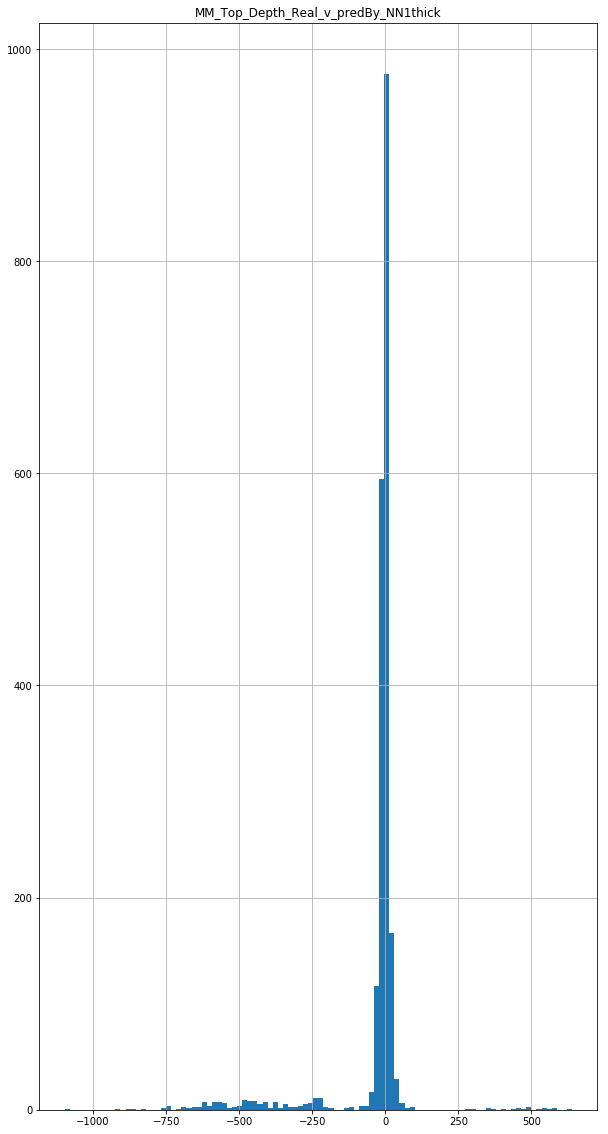

In [114]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1979aa58>]], dtype=object)

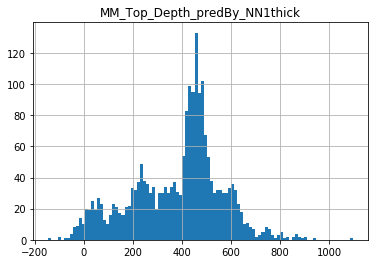

In [113]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
temp5.hist(column='MM_Top_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19114cc0>]], dtype=object)

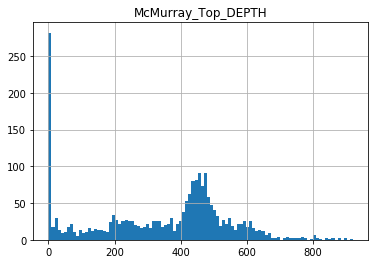

In [101]:
temp5.hist(column='McMurray_Top_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a192b6198>]], dtype=object)

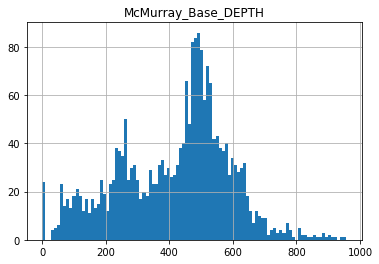

In [102]:
temp5.hist(column='McMurray_Base_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [103]:
df_test = temp5.copy()

In [104]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                            0
McMurray_Base_HorID              0
McMurray_Top_HorID               0
McMurray_Base_DEPTH              0
McMurray_Top_DEPTH               0
McMurray_Base_Qual               0
McMurray_Top_Qual                0
lat                              0
lng                              0
UWI                              0
Neighbors_Obj                    0
NN1_McMurray_Top_DEPTH          84
NN1_McMurray_Base_DEPTH          0
NN1_thickness                   84
MM_Top_Depth_predBy_NN1thick    84
dtype: int64

In [105]:
#### number of rows in each column with zero values
df_test[df_test.McMurray_Top_DEPTH == 0].count()

SitID                           247
McMurray_Base_HorID             247
McMurray_Top_HorID              247
McMurray_Base_DEPTH             247
McMurray_Top_DEPTH              247
McMurray_Base_Qual              247
McMurray_Top_Qual               247
lat                             247
lng                             247
UWI                             247
Neighbors_Obj                   247
NN1_McMurray_Top_DEPTH          168
NN1_McMurray_Base_DEPTH         247
NN1_thickness                   168
MM_Top_Depth_predBy_NN1thick    168
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [106]:
df_test[df_test.McMurray_Base_DEPTH == 0].count()

SitID                           24
McMurray_Base_HorID             24
McMurray_Top_HorID              24
McMurray_Base_DEPTH             24
McMurray_Top_DEPTH              24
McMurray_Base_Qual              24
McMurray_Top_Qual               24
lat                             24
lng                             24
UWI                             24
Neighbors_Obj                   24
NN1_McMurray_Top_DEPTH          24
NN1_McMurray_Base_DEPTH         24
NN1_thickness                   24
MM_Top_Depth_predBy_NN1thick    24
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19491240>]], dtype=object)

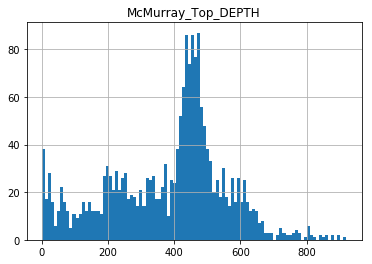

In [107]:
no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [115]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


/Users/justingosses/anaconda/envs/MannvilleDask/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18fac080>]], dtype=object)

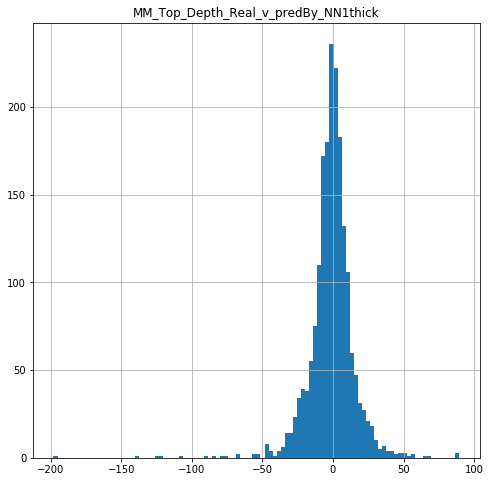

In [116]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [174]:
len(no_zeros_df)

1926

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [175]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [179]:
no_zeros_df_TopDepthVsNNleak

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick
0     102496                14000               13000               561.00              475.00                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0         [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.0874943032488}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.104516690327}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.109998964722}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.140172829054}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.145394974621}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482}]                  544.00                   630.00          86.00                        475.00
1     102497                14000               13000               604.50              515.00                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0     [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0733221383008}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0772558585092}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.078467559265}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0908970121511}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.116811594031}]                  529.00                   613.00          84.00                        520.50
2     102498                14000               13000               564.00              480.00                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0       [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.0575310019555}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0664937861909}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0826737666313}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.0872840016555}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.0934369191754}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.1080816692}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.120139676315}]                  529.00                   613.00          84.00                        480.00
3     102500                14000               13000               636.50              549.00                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0    [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.0435570060725}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.0458903640103}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.0473400060837}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.0520161525875}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.078988404744}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0816950542016}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.0875230112656}]                  529.00                   613.00          84.00   

In [177]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [119]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [120]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [168]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [169]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [170]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [171]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
    folium.CircleMarker(
    location=row[7:9],
    radius=2,
    color=depth_color(row[15:16][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 0.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is -5.5  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 0.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is -3.5  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 5.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is -0.5  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is -6.5  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 11.5  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 6.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is -25.5  and UWI is  00/07-36-067-03W4/0
location =  [54.771451, -11

location =  [54.942413, -110.70156200000001]  and depth is 28.0  and UWI is  00/07-04-069-05W4/0
location =  [54.971501, -110.66318400000002]  and depth is -28.0  and UWI is  00/05-14-069-05W4/0
location =  [54.985963, -110.682404]  and depth is -24.0  and UWI is  00/06-22-069-05W4/0
location =  [55.018671, -110.67612]  and depth is -8.0  and UWI is  00/10-34-069-05W4/0
location =  [54.985963, -110.83499199999999]  and depth is -8.0  and UWI is  00/06-22-069-06W4/0
location =  [55.015052000000004, -110.873301]  and depth is 0.5  and UWI is  00/08-32-069-06W4/0
location =  [55.015042, -110.784125]  and depth is -22.0  and UWI is  00/06-36-069-06W4/0
location =  [54.97150500000001, -111.000449]  and depth is 3.5  and UWI is  00/08-16-069-07W4/0
location =  [55.004192, -111.07006299999999]  and depth is -9.0  and UWI is  00/12-30-069-07W4/0
location =  [54.956865, -111.10216299999999]  and depth is 3.5  and UWI is  00/08-11-069-08W4/0
location =  [55.004212, -111.171774]  and depth is 10.

location =  [55.070554, -114.22126200000001]  and depth is 10.850000000000023  and UWI is  00/03-22-070-02W5/0
location =  [55.110387, -114.164345]  and depth is -1.0  and UWI is  00/15-36-070-02W5/0
location =  [55.02706, -114.379929]  and depth is 18.0  and UWI is  00/04-03-070-03W5/0
location =  [55.063318, -114.41831100000002]  and depth is -12.0  and UWI is  00/10-17-070-03W5/0
location =  [55.10324, -114.34836299999999]  and depth is -27.0  and UWI is  00/06-35-070-03W5/0
location =  [55.034209999999995, -114.469118]  and depth is -5.069999999999936  and UWI is  00/10-01-070-04W5/0
location =  [55.059670999999994, -114.577046]  and depth is 15.0  and UWI is  00/06-17-070-04W5/0
location =  [55.074133999999994, -114.462846]  and depth is 7.5  and UWI is  00/08-24-070-04W5/0
location =  [55.034211, -114.729482]  and depth is -27.57000000000005  and UWI is  00/11-05-070-05W5/0
location =  [55.048673, -114.67867700000001]  and depth is 27.57000000000005  and UWI is  00/11-10-070-05W5

location =  [55.262825, -110.61199099999999]  and depth is -11.5  and UWI is  00/06-30-072-04W4/0
location =  [55.204653, -110.63768600000002]  and depth is -6.5  and UWI is  00/06-01-072-05W4/0
location =  [55.208263, -110.766117]  and depth is -7.5  and UWI is  00/11-06-072-05W4/0
location =  [55.233757, -110.702059]  and depth is -1.0  and UWI is  00/08-16-072-05W4/0
location =  [55.266454, -110.66963500000001]  and depth is -5.5  and UWI is  00/12-26-072-05W4/0
location =  [55.208298, -110.874949]  and depth is -7.0  and UWI is  00/12-04-072-06W4/0
location =  [55.230192, -110.919978]  and depth is 5.350000000000023  and UWI is  00/03-18-072-06W4/0
location =  [55.266478, -110.874948]  and depth is 9.0  and UWI is  00/12-28-072-06W4/0
location =  [55.280927, -110.836724]  and depth is -19.0  and UWI is  00/10-34-072-06W4/0
location =  [55.208289, -110.93928799999999]  and depth is -2.0  and UWI is  00/10-01-072-07W4/0
location =  [55.222768, -111.041882]  and depth is 3.0  and UWI 

location =  [55.306425, -111.759795]  and depth is 1.0  and UWI is  00/07-10-073-12W4/0
location =  [55.30641899999999, -111.73415700000001]  and depth is 6.0  and UWI is  00/07-11-073-12W4/0
location =  [55.368196999999995, -111.84304099999999]  and depth is 8.5  and UWI is  00/11-31-073-12W4/0
location =  [55.295581000000006, -111.945595]  and depth is -10.5  and UWI is  00/11-04-073-13W4/0
location =  [55.342739, -111.926207]  and depth is 13.0  and UWI is  00/13-22-073-13W4/0
location =  [55.35374, -111.996872]  and depth is 9.0  and UWI is  00/11-30-073-13W4/0
location =  [55.364582999999996, -111.862349]  and depth is 5.5  and UWI is  00/07-36-073-13W4/0
location =  [55.291947, -112.15071100000002]  and depth is -2.589999999999975  and UWI is  00/06-06-073-14W4/0
location =  [55.30641899999999, -112.09943]  and depth is 12.589999999999975  and UWI is  00/06-09-073-14W4/0
location =  [55.335504, -112.118738]  and depth is -4.0499999999999545  and UWI is  00/07-20-073-14W4/0
locati

location =  [55.408319999999996, -111.15078500000001]  and depth is 5.5  and UWI is  00/06-15-074-08W4/0
location =  [55.411976, -111.227649]  and depth is 4.0  and UWI is  00/11-18-074-08W4/0
location =  [55.397361, -111.355833]  and depth is 15.230000000000018  and UWI is  00/11-08-074-09W4/0
location =  [55.397366000000005, -111.272604]  and depth is -4.0  and UWI is  00/10-11-074-09W4/0
location =  [55.412001000000004, -111.272601]  and depth is -8.139999999999986  and UWI is  00/10-14-074-09W4/0
location =  [55.437484999999995, -111.29824099999999]  and depth is 11.439999999999998  and UWI is  00/07-27-074-09W4/0
location =  [55.397302, -111.515965]  and depth is -8.000000000000057  and UWI is  00/12-08-074-10W4/0
location =  [55.43383299999999, -111.535357]  and depth is 6.7000000000000455  and UWI is  00/03-30-074-10W4/0
location =  [55.455459999999995, -111.445775]  and depth is -3.0  and UWI is  00/09-34-074-10W4/0
location =  [55.39368399999999, -111.663568]  and depth is -6.

location =  [55.499106000000005, -110.86936200000001]  and depth is -41.0  and UWI is  00/10-16-075-06W4/0
location =  [55.539013, -110.79811299999999]  and depth is 3.0  and UWI is  00/06-36-075-06W4/0
location =  [55.470020999999996, -111.024654]  and depth is -2.750000000000057  and UWI is  00/10-04-075-07W4/0
location =  [55.495475, -110.94700800000001]  and depth is 10.0  and UWI is  00/07-13-075-07W4/0
location =  [55.509944, -110.979281]  and depth is -13.720000000000027  and UWI is  00/06-23-075-07W4/0
location =  [55.542649, -110.998772]  and depth is -5.039999999999964  and UWI is  00/10-34-075-07W4/0
location =  [55.48445600000001, -111.21226499999999]  and depth is -4.149999999999977  and UWI is  00/11-08-075-08W4/0
location =  [55.499117000000005, -111.140892]  and depth is -18.31000000000006  and UWI is  00/12-14-075-08W4/0
location =  [55.52819399999999, -111.205858]  and depth is 22.460000000000036  and UWI is  00/10-29-075-08W4/0
location =  [55.539039, -111.1281870000

location =  [55.615446999999996, -110.817605]  and depth is 4.0  and UWI is  AA/10-26-076-06W4/0
location =  [55.61545699999999, -110.862972]  and depth is 13.28000000000003  and UWI is  AA/09-28-076-06W4/0
location =  [55.55727099999999, -111.076419]  and depth is 9.939999999999998  and UWI is  00/10-06-076-07W4/0
location =  [55.582755000000006, -110.979281]  and depth is 9.0  and UWI is  AA/06-14-076-07W4/0
location =  [55.586366000000005, -110.97288999999999]  and depth is 3.0  and UWI is  AA/10-14-076-07W4/0
location =  [55.59719499999999, -110.94700800000001]  and depth is -9.0  and UWI is  00/07-24-076-07W4/0
location =  [55.571732999999995, -111.205802]  and depth is 4.3700000000000045  and UWI is  00/10-08-076-08W4/0
location =  [55.571735, -111.128198]  and depth is 3.5400000000000205  and UWI is  00/10-11-076-08W4/0
location =  [55.600823, -111.128192]  and depth is -2.640000000000043  and UWI is  00/10-23-076-08W4/0
location =  [55.629906000000005, -111.20582900000001]  and

location =  [55.64451, -110.60416200000002]  and depth is 1.5  and UWI is  00/09-06-077-04W4/0
location =  [55.66641800000001, -110.50703100000001]  and depth is -24.0  and UWI is  00/02-14-077-04W4/0
location =  [55.684427, -110.623253]  and depth is -23.5  and UWI is  00/05-19-077-04W4/0
location =  [55.637328000000004, -110.642824]  and depth is -11.5  and UWI is  00/03-01-077-05W4/0
location =  [55.666419999999995, -110.64913500000002]  and depth is 8.5  and UWI is  00/04-13-077-05W4/0
location =  [55.684456000000004, -110.73356899999999]  and depth is 6.0  and UWI is  00/08-20-077-05W4/0
location =  [55.684456000000004, -110.68819599999999]  and depth is -6.0  and UWI is  00/07-22-077-05W4/0
location =  [55.658995, -110.92753]  and depth is -3.659999999999968  and UWI is  00/11-07-077-06W4/0
location =  [55.66999200000001, -110.791725]  and depth is 5.0  and UWI is  00/07-13-077-06W4/0
location =  [55.670018999999996, -110.875759]  and depth is 10.5  and UWI is  00/06-16-077-06W4/

location =  [55.749832999999995, -110.610549]  and depth is 10.5  and UWI is  00/15-07-078-04W4/0
location =  [55.75725500000001, -110.54560500000001]  and depth is -10.5  and UWI is  00/05-15-078-04W4/0
location =  [55.77169, -110.61693799999999]  and depth is 28.060000000000002  and UWI is  00/06-19-078-04W4/0
location =  [55.771708, -110.539294]  and depth is 3.5600000000000023  and UWI is  00/06-22-078-04W4/0
location =  [55.728177, -110.72677900000001]  and depth is -2.0  and UWI is  00/05-04-078-05W4/0
location =  [55.771717, -110.726777]  and depth is -11.0  and UWI is  00/05-21-078-05W4/0
location =  [55.786334, -110.772231]  and depth is 7.0  and UWI is  00/06-30-078-05W4/0
location =  [55.797192, -110.69458200000001]  and depth is 14.5  and UWI is  00/03-34-078-05W4/0
location =  [55.731801000000004, -110.90166599999999]  and depth is -0.5  and UWI is  00/11-05-078-06W4/0
location =  [55.76089, -110.82399299999999]  and depth is -3.0  and UWI is  00/11-14-078-06W4/0
location 

location =  [55.89165, -110.772255]  and depth is -2.0  and UWI is  00/10-31-079-05W4/0
location =  [55.815431000000004, -110.87023700000002]  and depth is 10.0  and UWI is  00/08-04-079-06W4/0
location =  [55.829862, -110.804803]  and depth is 2.5  and UWI is  00/06-12-079-06W4/0
location =  [55.877174, -110.883156]  and depth is -14.0  and UWI is  00/11-28-079-06W4/0
location =  [55.887995, -110.902819]  and depth is -2.5  and UWI is  00/07-32-079-06W4/0
location =  [55.818993000000006, -111.013691]  and depth is -11.5  and UWI is  00/11-03-079-07W4/0
location =  [55.833431000000004, -110.98113899999998]  and depth is 0.0  and UWI is  00/10-11-079-07W4/0
location =  [55.877148999999996, -110.95501999999999]  and depth is 10.5  and UWI is  00/10-25-079-07W4/0
location =  [55.891620999999994, -111.039749]  and depth is 1.0  and UWI is  00/11-33-079-07W4/0
location =  [55.833482, -111.21598600000002]  and depth is 3.0  and UWI is  AA/10-08-079-08W4/0
location =  [55.833429, -111.111624]

location =  [55.920730000000006, -111.294288]  and depth is 9.0  and UWI is  00/10-11-080-09W4/0
location =  [55.96445, -111.29428700000001]  and depth is -9.0  and UWI is  AA/10-26-080-09W4/0
location =  [55.964449, -111.372593]  and depth is 4.28000000000003  and UWI is  00/10-29-080-09W4/0
location =  [55.917114, -111.529223]  and depth is 2.2200000000000273  and UWI is  AA/07-08-080-10W4/0
location =  [55.924344999999995, -111.477011]  and depth is -2.2200000000000273  and UWI is  00/15-10-080-10W4/0
location =  [55.960831000000006, -111.450905]  and depth is 8.019999999999982  and UWI is  AA/07-26-080-10W4/0
location =  [55.902661, -111.67256100000002]  and depth is 2.5  and UWI is  00/05-04-080-11W4/0
location =  [55.920722999999995, -111.60753999999999]  and depth is 6.389999999999986  and UWI is  AA/10-11-080-11W4/0
location =  [55.931748999999996, -111.646455]  and depth is -10.339999999999975  and UWI is  00/05-15-080-11W4/0
location =  [55.960829000000004, -111.6075389999999

location =  [56.03346, -111.47701200000002]  and depth is 0.5  and UWI is  00/07-22-081-10W4/0
location =  [56.0517, -111.450907]  and depth is -0.46999999999997044  and UWI is  00/10-26-081-10W4/0
location =  [56.022605000000006, -111.58788100000001]  and depth is 11.009999999999991  and UWI is  00/11-13-081-11W4/0
location =  [56.040678, -111.607541]  and depth is -5.5  and UWI is  AA/15-23-081-11W4/0
location =  [56.048088, -111.679409]  and depth is 8.620000000000005  and UWI is  AA/08-29-081-11W4/0
location =  [55.997128000000004, -111.744505]  and depth is -4.0  and UWI is  00/14-01-081-12W4/0
location =  [56.022597999999995, -111.86211999999999]  and depth is -10.0  and UWI is  00/09-18-081-12W4/0
location =  [56.051697, -111.816364]  and depth is -3.0  and UWI is  00/10-28-081-12W4/0
location =  [56.062535, -111.829172]  and depth is -2.0  and UWI is  00/05-33-081-12W4/0
location =  [56.007964, -111.99908500000001]  and depth is 0.0  and UWI is  AA/10-08-081-13W4/0
location =  

location =  [56.120706000000006, -111.79671299999998]  and depth is -0.5  and UWI is  00/06-22-082-12W4/0
location =  [56.080776, -111.946878]  and depth is -2.5  and UWI is  00/10-03-082-13W4/0
location =  [56.07714300000001, -112.03164199999999]  and depth is 1.25  and UWI is  00/06-06-082-13W4/0
location =  [56.09522, -111.914327]  and depth is -3.0  and UWI is  AA/09-11-082-13W4/0
location =  [56.124313, -111.97299]  and depth is 2.5  and UWI is  00/10-21-082-13W4/0
location =  [56.138940000000005, -111.999098]  and depth is -4.840000000000032  and UWI is  00/10-29-082-13W4/0
location =  [56.080757, -112.181804]  and depth is 2.0  and UWI is  00/10-06-082-14W4/0
location =  [56.10985600000001, -112.129601]  and depth is -6.0  and UWI is  00/10-16-082-14W4/0
location =  [56.135328, -112.109945]  and depth is 3.3700000000000045  and UWI is  00/06-27-082-14W4/0
location =  [56.09521899999999, -112.312257]  and depth is -0.5  and UWI is  00/10-08-082-15W4/0
location =  [56.135313000000

location =  [56.208068000000004, -112.39253300000001]  and depth is -6.399999999999977  and UWI is  00/06-24-083-16W4/0
location =  [56.237190000000005, -112.43868300000001]  and depth is 3.5  and UWI is  00/07-34-083-16W4/0
location =  [56.211692000000006, -112.68212700000001]  and depth is -7.5  and UWI is  00/11-19-083-17W4/0
location =  [56.226344999999995, -112.550525]  and depth is -21.340000000000032  and UWI is  00/11-25-083-17W4/0
location =  [56.237171, -112.682148]  and depth is 0.0  and UWI is  00/06-31-083-17W4/0
location =  [56.193659, -112.728306]  and depth is 5.5  and UWI is  00/07-14-083-18W4/0
location =  [56.208113, -112.734821]  and depth is 9.170000000000016  and UWI is  00/06-23-083-18W4/0
location =  [56.222719, -112.70197399999999]  and depth is 0.0  and UWI is  00/07-25-083-18W4/0
location =  [56.22275, -112.761177]  and depth is -6.069999999999993  and UWI is  00/06-27-083-18W4/0
location =  [56.226339, -112.86003600000001]  and depth is -9.749999999999943  a

location =  [56.335468000000006, -112.326844]  and depth is -9.0  and UWI is  00/01-05-085-15W4/0
location =  [56.371795, -112.52423799999998]  and depth is -9.0  and UWI is  00/11-18-085-16W4/0
location =  [56.379020999999995, -112.58340700000001]  and depth is 10.5  and UWI is  00/04-23-085-17W4/0
location =  [56.415341000000005, -112.57691100000001]  and depth is -6.319999999999993  and UWI is  00/11-35-085-17W4/0
location =  [56.37176899999999, -113.10358899999999]  and depth is -25.599999999999966  and UWI is  00/11-16-085-20W4/0
location =  [56.386223, -113.472371]  and depth is 9.460000000000036  and UWI is  00/11-19-085-22W4/0
location =  [56.339105, -113.571226]  and depth is 16.850000000000023  and UWI is  00/07-04-085-23W4/0
location =  [56.408102, -113.61048999999998]  and depth is 14.819999999999993  and UWI is  00/04-32-085-23W4/0
location =  [56.411703, -113.498709]  and depth is -10.970000000000027  and UWI is  00/06-36-085-23W4/0
location =  [56.382631999999994, -113.7

location =  [56.669821, -111.470846]  and depth is -15.240000000000009  and UWI is  AA/01-35-088-10W4/0
location =  [56.629898, -111.789818]  and depth is -4.260000000000019  and UWI is  AA/08-14-088-12W4/0
location =  [56.651585, -111.836091]  and depth is 0.6099999999999852  and UWI is  AA/13-22-088-12W4/0
location =  [56.677001000000004, -112.068776]  and depth is 1.8900000000000148  and UWI is  AA/11-31-088-13W4/0
location =  [56.662552000000005, -112.1951]  and depth is -1.7199999999999989  and UWI is  AA/10-29-088-14W4/0
location =  [56.680631999999996, -112.161971]  and depth is -3.8499999999999943  and UWI is  AA/16-33-088-14W4/0
location =  [56.618854000000006, -112.35453500000001]  and depth is 2.5  and UWI is  AA/10-08-088-15W4/0
location =  [56.618849, -112.514076]  and depth is -9.620000000000005  and UWI is  AA/10-08-088-16W4/0
location =  [56.618862, -112.434276]  and depth is 2.0  and UWI is  AA/10-11-088-16W4/0
location =  [56.662564, -112.434344]  and depth is -2.0  a

location =  [56.869980000000005, -111.323678]  and depth is 4.260000000000005  and UWI is  AA/16-02-091-09W4/0
location =  [56.899074, -111.39718400000001]  and depth is -25.60000000000001  and UWI is  AA/13-16-091-09W4/0
location =  [56.938995999999996, -111.303494]  and depth is -4.88000000000001  and UWI is  AA/10-36-091-09W4/0
location =  [56.877201, -111.497932]  and depth is -7.5  and UWI is  AA/06-11-091-10W4/0
location =  [56.902643000000005, -111.77269]  and depth is -10.289999999999992  and UWI is  AA/04-19-091-11W4/0
location =  [56.895419999999994, -111.78635200000001]  and depth is 10.289999999999992  and UWI is  AA/10-13-091-12W4/0
location =  [56.902646, -111.786353]  and depth is 3.289999999999992  and UWI is  AA/02-24-091-12W4/0
location =  [56.891822999999995, -112.034526]  and depth is 4.469999999999999  and UWI is  AA/06-16-091-13W4/0
location =  [56.93174499999999, -112.034527]  and depth is -7.5  and UWI is  AA/03-33-091-13W4/0
location =  [56.880798999999996, -11

location =  [57.153575, -111.417409]  and depth is -16.5  and UWI is  AB/06-17-094-09W4/0
location =  [57.175252, -111.336977]  and depth is 18.0  and UWI is  AA/14-23-094-09W4/0
location =  [57.1971, -111.31668799999998]  and depth is -20.0  and UWI is  AA/05-36-094-09W4/0
location =  [57.128142000000004, -111.471075]  and depth is -1.5  and UWI is  AA/11-01-094-10W4/0
location =  [57.135376, -111.504535]  and depth is 1.5  and UWI is  AA/04-11-094-10W4/0
location =  [57.164464, -111.504529]  and depth is -25.0  and UWI is  AA/04-23-094-10W4/0
location =  [57.193536, -111.52472]  and depth is 49.59  and UWI is  AA/03-34-094-10W4/0
location =  [57.128114000000004, -111.772749]  and depth is 10.0  and UWI is  AB/12-06-094-11W4/0
location =  [57.13896, -111.652289]  and depth is 4.880000000000001  and UWI is  AB/07-11-094-11W4/0
location =  [57.153601, -111.705867]  and depth is 8.23  and UWI is  AA/07-16-094-11W4/0
location =  [57.186298, -111.752866]  and depth is -22.859999999999992  

location =  [57.419019999999996, -111.127245]  and depth is 14.5  and UWI is  AA/10-18-097-07W4/0
location =  [57.4481, -111.127246]  and depth is -23.0  and UWI is  AA/10-30-097-07W4/0
location =  [57.462561, -111.100167]  and depth is 32.0  and UWI is  AA/10-32-097-07W4/0
location =  [57.382728, -111.248855]  and depth is -22.5  and UWI is  AA/04-04-097-08W4/0
location =  [57.407998, -111.154326]  and depth is -14.5  and UWI is  AA/15-12-097-08W4/0
location =  [57.437079000000004, -111.154327]  and depth is 15.320000000000002  and UWI is  AA/15-24-097-08W4/0
location =  [57.40799499999999, -111.45885600000001]  and depth is 10.0  and UWI is  AA/14-07-097-09W4/0
location =  [57.4154, -111.458868]  and depth is -21.0  and UWI is  AA/06-18-097-09W4/0
location =  [57.444480000000006, -111.45891499999999]  and depth is 35.0  and UWI is  AA/06-30-097-09W4/0
location =  [57.389922, -111.628091]  and depth is 24.0  and UWI is  AA/12-06-097-10W4/0
location =  [57.411793, -111.60805500000001] 

In [172]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [173]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [12]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [13]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [9]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [10]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [11]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow